Problem/Hypothesis: By employing market trading strategies based on moving day averages, can one beat market performance of simply buying and holding stocks for the long term? 

Note: The following code is taken entirely from a data science project https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/ . I have taken care to understand each line and, where necessary, modify it for my purposes.

The following cell imports stock data (Amazon) from Yahoo Finance from January 1, 2016 to present. I used pandas.io.data as web--package and module for importing data.

In [1]:
import pandas as pd
import pandas.io.data as web   # Package and modules for importing data; this code may change depending on pandas version
import datetime
 
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()
 
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = web.DataReader("AAPL", "yahoo", start, end)
 
type(apple)

C:\Users\Jae Lee\Anaconda2\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


pandas.core.frame.DataFrame

In [2]:
apple.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,102.610001,105.370003,102.000000,105.349998,67649400,103.057063
2016-01-05,105.750000,105.849998,102.410004,102.709999,55791000,100.474523
2016-01-06,100.559998,102.370003,99.870003,100.699997,68457400,98.508268
2016-01-07,98.680000,100.129997,96.430000,96.449997,81094400,94.350769
2016-01-08,98.550003,99.110001,96.760002,96.959999,70798000,94.849671


"Open" is the price of the stock at the beginning of the trading day (it need not be the closing price of the previous trading day), "High" is the highest price of the stock on that trading day, "Low" the lowest price of the stock on that trading day, and close the price of the stock at closing time. "Volume" indicates how many stocks were traded. "Adjusted close" is the closing price of the stock that adjusts the price of the stock for corporate actions. While stock prices are considered to be set mostly by traders, stock splits (when the company makes each extant stock worth two and halves the price) and dividends (payout of company profits per share) also affect the price of a stock and should be accounted for.

Populating the interactive namespace from numpy and matplotlib


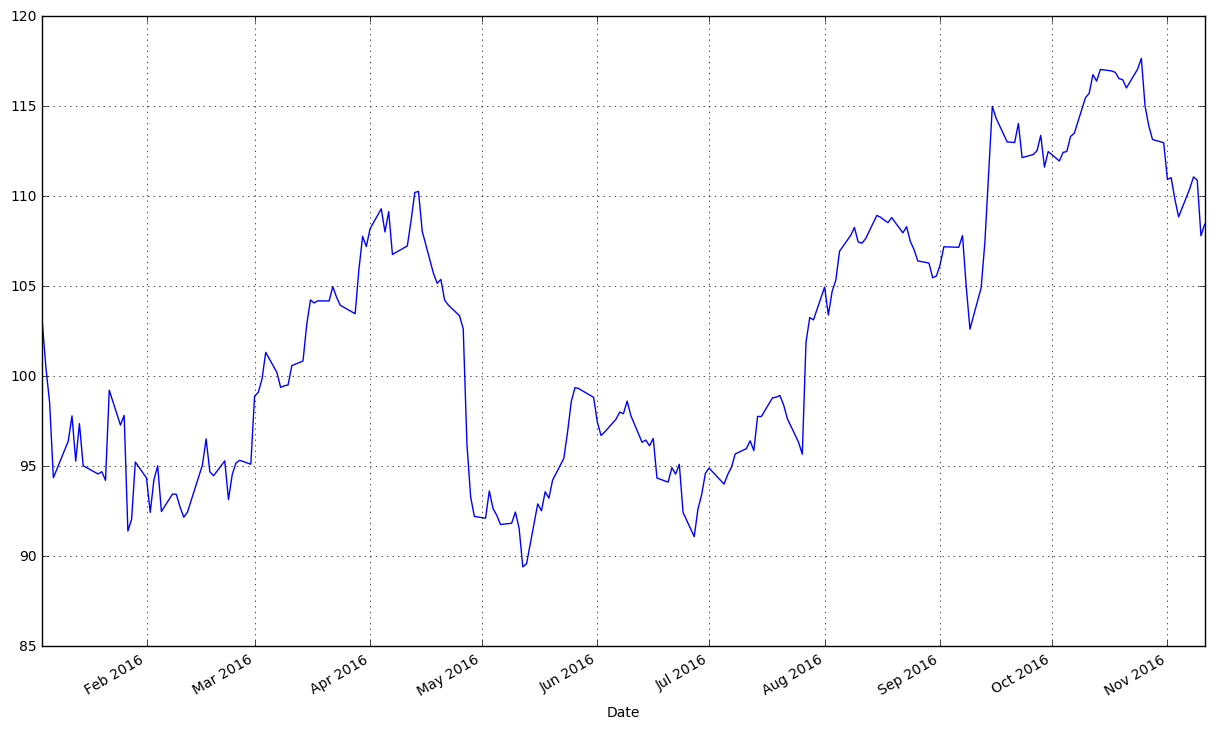

In [3]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj Close"].plot(grid = True) # Plot the adjusted closing price of AAPL


The following code is based off this example:http://matplotlib.org/examples/pylab_examples/finance_demo.html; the documentation for the functions involved: http://matplotlib.org/api/finance_api.html

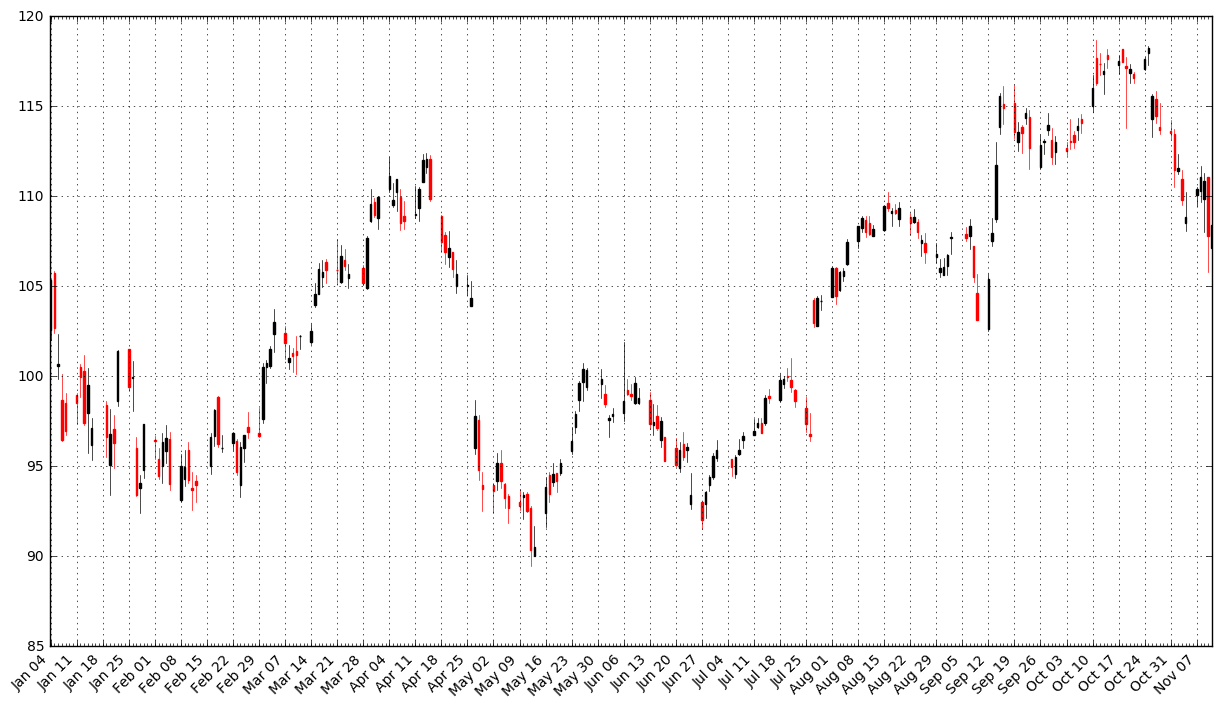

In [4]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
                
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)

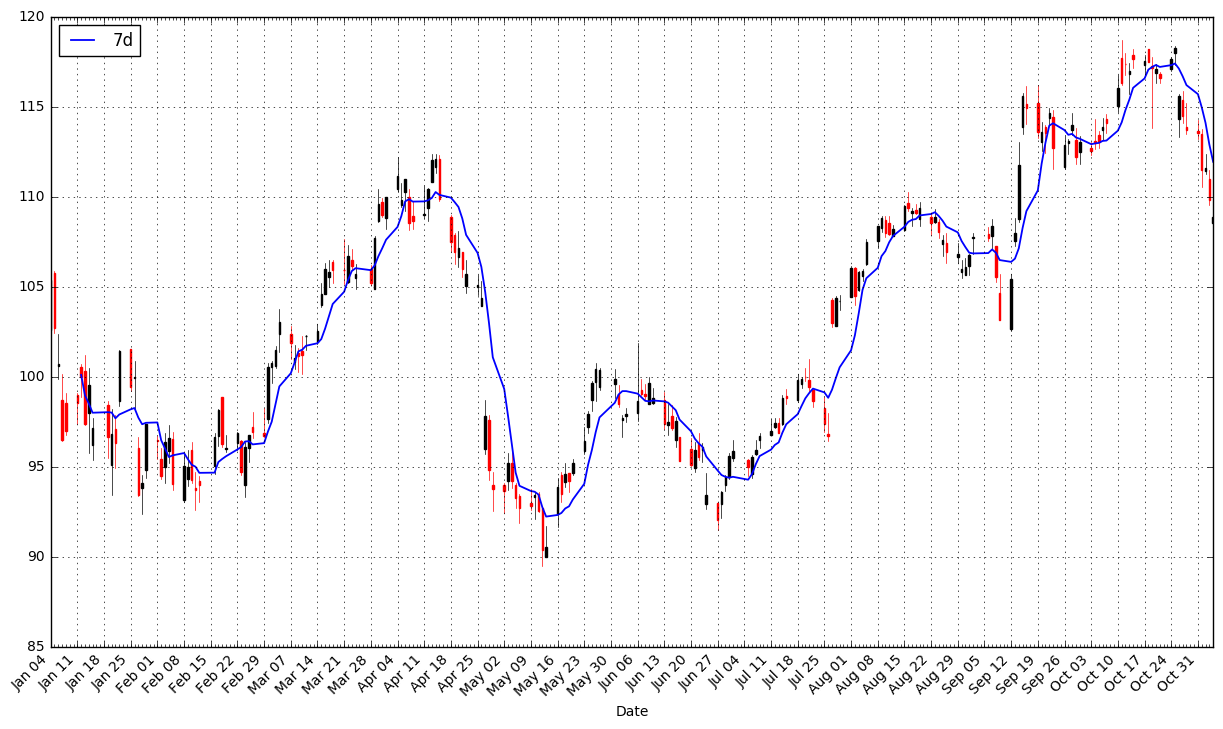

In [63]:
import numpy as np

apple["7d"] = np.round(apple["Close"].rolling(window = 7, center = False).mean(), 2)

pandas_candlestick_ohlc(apple.loc['2016-01-01':'2016-11-07',:], otherseries = ["7d"])

In my study, I utilize a 7, 15, 21, 39, and 72-day moving average crossover system to trigger buy/sell signals. A stock price crossings are what we can use as trading signals (or in the very least indications that a financial security is changing direction).

In Pandas, there are functions to compute moving (rolling) statistics, such as rolling_mean and rolling_std., and I will call these functions for this study.

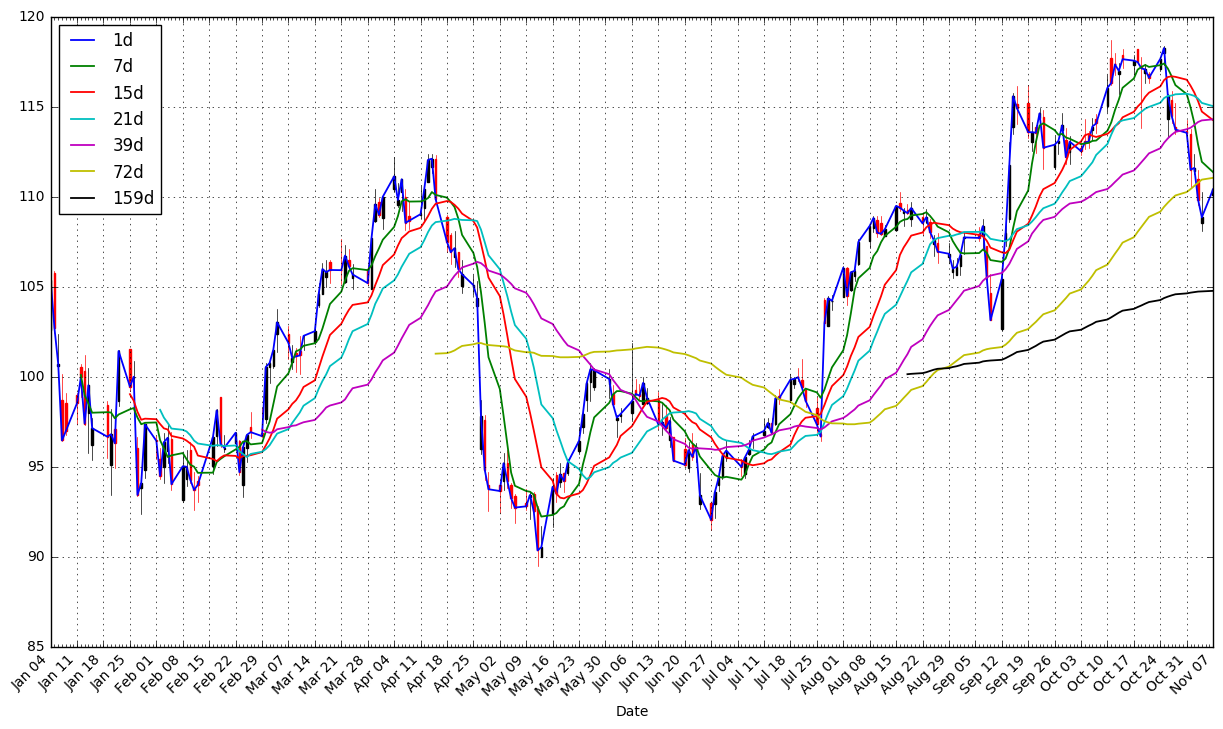

In [6]:
apple["1d"] = np.round(apple["Close"].rolling(window = 1, center = False).mean(), 2)
apple["7d"] = np.round(apple["Close"].rolling(window = 7, center = False).mean(), 2)
apple["15d"] = np.round(apple["Close"].rolling(window = 15, center = False).mean(), 2)
apple["21d"] = np.round(apple["Close"].rolling(window = 21, center = False).mean(), 2)
apple["39d"] = np.round(apple["Close"].rolling(window = 39, center = False).mean(), 2)
apple["72d"] = np.round(apple["Close"].rolling(window = 72, center = False).mean(), 2) 
apple["159d"] = np.round(apple["Close"].rolling(window = 159, center = False).mean(), 2)
#apple["599d"] = np.round(apple["Close"].rolling(window = 599, center = False).mean(), 2)

pandas_candlestick_ohlc(apple.loc['2016-01-01':'2016-11-07',:], otherseries = ["1d", "7d", "15d", "21d", "39d", "72d", "159d"])

Trading Definition: Buying and holding unto a stock with the expectation that the stock will increase in value is a called "long" position.

A "short" position, or "shorting a stock," is when you borrow a stock (from a brokerage firm) and sell it, with the expectation that the stock will decrease in value and then purchasing back the stock back at some future date at a lower price, earning a profit of the difference between your selling price and your repurchase price.

General Trading Strategies: 

Asset Allocation: a set of rules that determine how much of her money she is willing to allocate on any single trade (e.g. no more than 1% of the entire portolio value in any one trade).  

Exit Strategies: a set of conditions determining when he or will will exit the position (either long or short), for either profit or loss. A trader may set a target for the exit price which is determined either arbitrarily or through a set of rules.

Trading Strategies: When to buy and sell.

A trading stretegy is a means for deciding when to enter and exit a position.

Utilizing a 7, 15, 21, 39, 72, and 159-day moving average support/crossover system, I will program and test a trading strategy utilizing various moving averages as the basis for my trading system.

Short term: If a price is trading above, or "breaks out" above 7, 15, 21, 39-day moving averages, the trading system would trigger a buy. Thereafter, if it crosses below a 15-day moving average, it would trigger a sell.

Long term: If a price is trading above, or "breaks out" above 7, 15, 21, 39, 72, and 159-day moving averages, the trading system would trigger a buy. If it crosses below the 72-day average, it would trigger a sell.

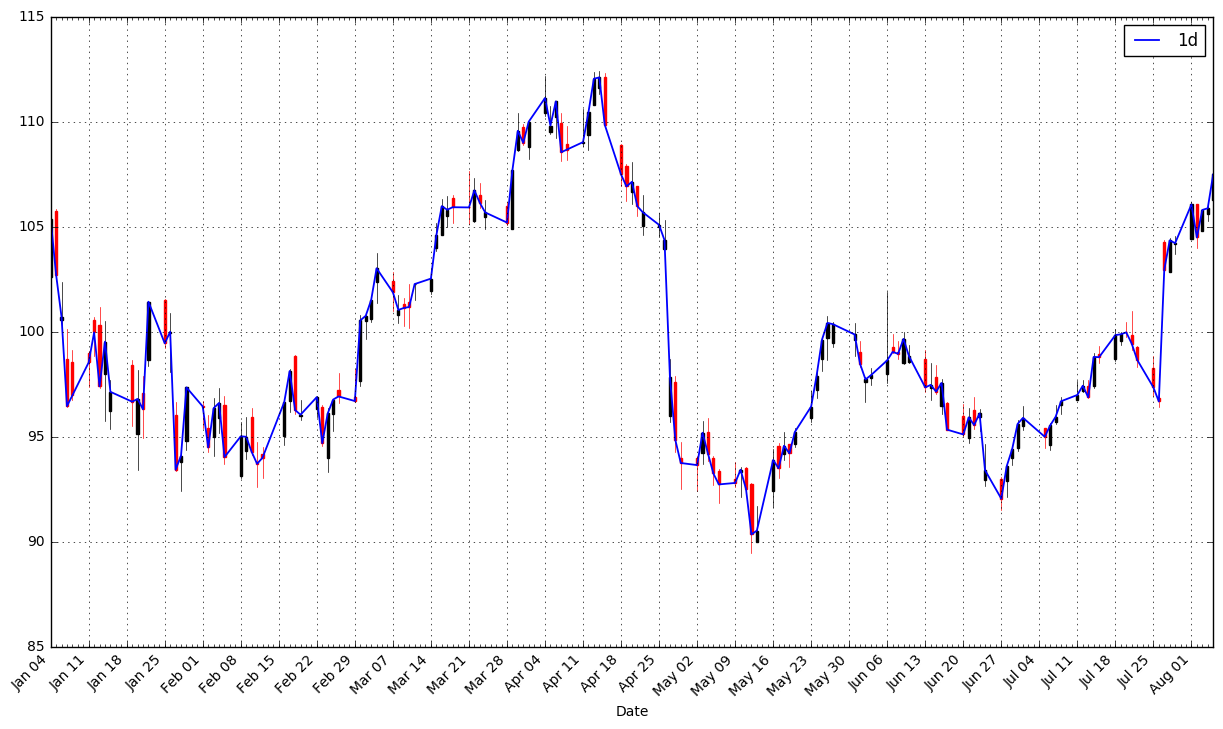

In [7]:
apple["1d"] = np.round(apple["Close"].rolling(window = 1, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "1d")

In [11]:

apple = web.DataReader("AAPL", "yahoo", start, end)
 
type(apple)
apple["1d"] = np.round(apple["Close"].rolling(window = 1, center = False).mean(), 2)
apple['1d-7d'] = apple['1d'] - apple['7d']
apple.tail()

KeyError: '7d'

In [46]:
signals = ma_crossover_orders([("AAPL", ohlc_adj(apple)),
                              ("MSFT",  ohlc_adj(microsoft)),
                              ("GOOG",  ohlc_adj(google)),
                              ("FB",    ohlc_adj(facebook)),
                              ("TWTR",  ohlc_adj(twitter)),
                              ("CF",    ohlc_adj(cfholdings)),
                              ("AMZN",  ohlc_adj(amazon)),
                              ("YHOO",  ohlc_adj(yahoo)),
                              ("SNY",   ohlc_adj(yahoo)),
                              ("NTDOY", ohlc_adj(nintendo)),
                              ("IBM",   ohlc_adj(ibm)),
                              ("HPQ",   ohlc_adj(hp))],
                            fast = 20, slow = 50)
signals

Price  Regime Signal
Date       Symbol                           
2010-03-16 AAPL     29.205718     1.0    Buy
           AMZN    131.789993     1.0    Buy
           CF       17.219170     1.0    Buy
           GOOG    282.318173    -1.0   Sell
           HPQ      20.539689     1.0    Buy
           IBM     110.563240     1.0    Buy
           MSFT     24.677580    -1.0   Sell
           NTDOY    37.099998     1.0    Buy
           SNY      16.360001    -1.0   Sell
           YHOO     16.360001    -1.0   Sell
2010-03-17 SNY      16.500000     1.0    Buy
           YHOO     16.500000     1.0    Buy
2010-03-22 GOOG    278.472004     1.0    Buy
2010-03-23 MSFT     25.106096     1.0    Buy
2010-03-29 CF       16.734757    -1.0   Sell
2010-05-03 GOOG    265.035411    -1.0   Sell
2010-05-10 HPQ      19.264541    -1.0   Sell
2010-05-14 NTDOY    35.799999    -1.0   Sell
2010-05-17 SNY      16.270000    -1.0   Sell
           YHOO     16.270000    -1.0   Sell
2010-05-19 AMZN    124.589996    -1.0   Sell
           MSFT     23.835187    -1.0   Sell
2010-05-21 IBM     108.322991    -1.0   Sell
2010-06-10 AAPL     32.596679     0.0   Sell
2010-06-11 AAPL     32.987041    -1.0   Sell
2010-06-18 AAPL     35.662337     1.0    Buy
2010-06-28 IBM     111.397697     1.0    Buy
2010-07-01 IBM     105.861499    -1.0   Sell
2010-07-06 IBM     106.630175     1.0    Buy
2010-07-09 NTDOY    36.950001     1.0    Buy
...                       ...     ...    ...
2016-07-25 FB      121.629997     1.0    Buy
2016-07-26 GOOG    738.419983     1.0    Buy
2016-09-09 CF       25.000000     1.0    Buy
2016-09-14 IBM     154.050003    -1.0   Sell
2016-09-30 MSFT     57.599998     0.0   Sell
2016-10-03 MSFT     57.419998    -1.0   Sell
2016-10-06 GOOG    776.859985    -1.0   Sell
2016-10-07 CF       23.950001    -1.0   Sell
2016-10-10 GOOG    785.940002     1.0    Buy
2016-10-18 MSFT     57.660000     1.0    Buy
2016-10-19 SNY      42.730000    -1.0   Sell
           YHOO     42.730000    -1.0   Sell
2016-10-20 MSFT     57.250000    -1.0   Sell
2016-10-21 MSFT     59.660000     1.0    Buy
2016-10-26 TWTR     17.290001    -1.0   Sell
2016-10-31 HPQ      14.490000     0.0   Sell
           NTDOY    30.090000    -1.0   Sell
2016-11-01 HPQ      14.350000    -1.0   Sell
2016-11-04 AAPL    108.839996     1.0   Sell
           AMZN    755.049988     1.0   Sell
           CF       23.110001    -1.0    Buy
           FB      120.750000     1.0   Sell
           GOOG    762.020020     1.0   Sell
           HPQ      14.710000    -1.0    Buy
           IBM     152.429993    -1.0    Buy
           MSFT     58.709999     1.0   Sell
           NTDOY    29.430000    -1.0    Buy
           SNY      40.279999    -1.0    Buy
           TWTR     18.020000    -1.0    Buy
           YHOO     40.279999    -1.0    Buy

[491 rows x 3 columns]

In [47]:
bk = backtest(signals, 1000000)
bk

End Cash  Portfolio Value  Profit per Share  \
Date       Symbol                                                    
2010-03-16 AAPL    9.007006e+05     1.000000e+06          0.000000   
           AMZN    8.084476e+05     1.000000e+06          0.000000   
           CF      7.085764e+05     1.000000e+06          0.000000   
           GOOG    7.085764e+05     1.000000e+06          0.000000   
           HPQ     6.099859e+05     1.000000e+06          0.000000   
           IBM     5.104790e+05     1.000000e+06          0.000000   
           MSFT    5.104790e+05     1.000000e+06          0.000000   
           NTDOY   4.140190e+05     1.000000e+06          0.000000   
           SNY     4.140190e+05     1.000000e+06          0.000000   
           YHOO    4.140190e+05     1.000000e+06          0.000000   
2010-03-17 SNY     3.150190e+05     1.000000e+06          0.000000   
           YHOO    2.160190e+05     1.000000e+06          0.000000   
2010-03-22 GOOG    1.324774e+05     1.000000e+06          0.000000   
2010-03-23 MSFT    3.456358e+04     1.000000e+06          0.000000   
2010-03-29 CF      1.316252e+05     9.971904e+05         -0.484413   
2010-05-03 GOOG    2.111358e+05     9.931594e+05        -13.436593   
2010-05-10 HPQ     3.036056e+05     9.870387e+05         -1.275148   
2010-05-14 NTDOY   3.966856e+05     9.836587e+05         -1.299999   
2010-05-17 SNY     4.943056e+05     9.822787e+05         -0.230000   
           YHOO    5.919256e+05     9.808987e+05         -0.230000   
2010-05-19 AMZN    6.791386e+05     9.758587e+05         -7.199997   
           MSFT    7.720958e+05     9.709022e+05         -1.270909   
2010-05-21 IBM     8.695865e+05     9.688860e+05         -2.240249   
2010-06-10 AAPL    9.804152e+05     9.804152e+05          3.390961   
2010-06-11 AAPL    9.804152e+05     9.804152e+05          3.781323   
2010-06-18 AAPL    8.841269e+05     9.804152e+05          0.000000   
2010-06-28 IBM     7.950088e+05     9.804152e+05          0.000000   
2010-07-01 IBM     8.796980e+05     9.759863e+05         -5.536198   
2010-07-06 IBM     7.837308e+05     9.759863e+05          0.000000   
2010-07-09 NTDOY   6.876608e+05     9.759863e+05          0.000000   
...                         ...              ...               ...   
2016-07-25 FB      7.051546e+04     1.552851e+06          0.000000   
2016-07-26 GOOG   -7.716854e+04     1.552851e+06          0.000000   
2016-09-09 CF     -2.321685e+05     1.552851e+06          0.000000   
2016-09-14 IBM    -7.811854e+04     1.555369e+06          2.518727   
2016-09-30 MSFT    8.892146e+04     1.567529e+06          4.192865   
2016-10-03 MSFT    8.892146e+04     1.567529e+06          4.012865   
2016-10-06 GOOG    2.442935e+05     1.575217e+06         38.440002   
2016-10-07 CF      3.927835e+05     1.568707e+06         -1.049999   
2016-10-10 GOOG    3.141895e+05     1.568707e+06          0.000000   
2016-10-18 MSFT    1.585075e+05     1.568707e+06          0.000000   
2016-10-19 SNY     3.294275e+05     1.587667e+06          4.739998   
           YHOO    5.003475e+05     1.606627e+06          4.739998   
2016-10-20 MSFT    6.549225e+05     1.605520e+06         -0.410000   
2016-10-21 MSFT    4.998065e+05     1.605520e+06          0.000000   
2016-10-26 TWTR    6.536875e+05     1.607745e+06          0.250000   
2016-10-31 HPQ     8.188735e+05     1.619661e+06          1.045289   
           NTDOY   9.873775e+05     1.633045e+06          2.389999   
2016-11-01 HPQ     9.873775e+05     1.633045e+06          0.905289   
2016-11-04 AAPL    1.161521e+06     1.653075e+06         12.519002   
           AMZN    1.312531e+06     1.692197e+06        195.609986   
           CF      1.312531e+06     1.692197e+06         -1.889999   
           FB      1.457431e+06     1.691141e+06         -0.879997   
           GOOG    1.533633e+06     1.688749e+06        -23.919982   
           HPQ     1.533633e+06     1.688749e+06          1.265289   
           IBM     1.533633e+06  

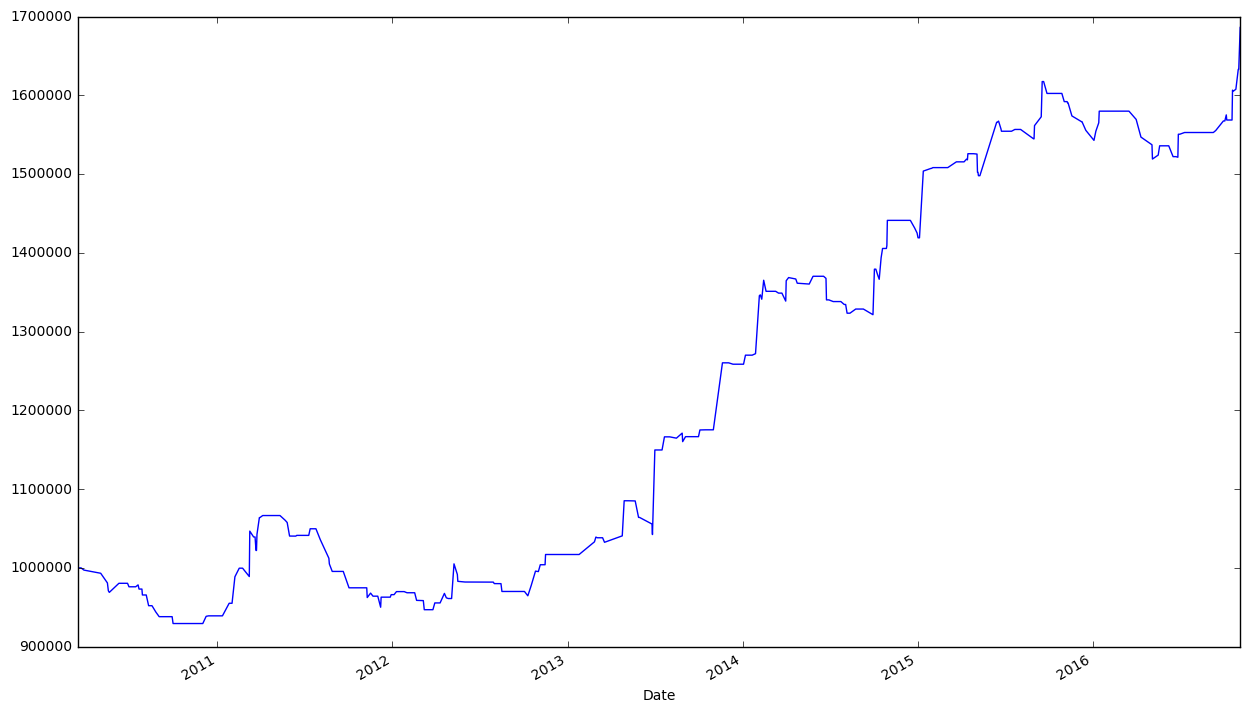

In [48]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()

In [49]:
spyder = web.DataReader("SPY", "yahoo", start, end)
spyder.iloc[[0,-1],:]

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,118944600,98.793254
2016-11-04,208.910004,209.889999,208.380005,208.550003,102681600,208.550003


In [50]:
batches = 1000000 // np.ceil(100 * spyder.ix[0,"Adj Close"]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * spyder.ix[0,"Adj Close"] # How much money is used to buy SPY
final_val = batches * batch * spyder.ix[-1,"Adj Close"] + (1000000 - trade_val) # Final value of the portfolio
final_val

2108543.1649000002

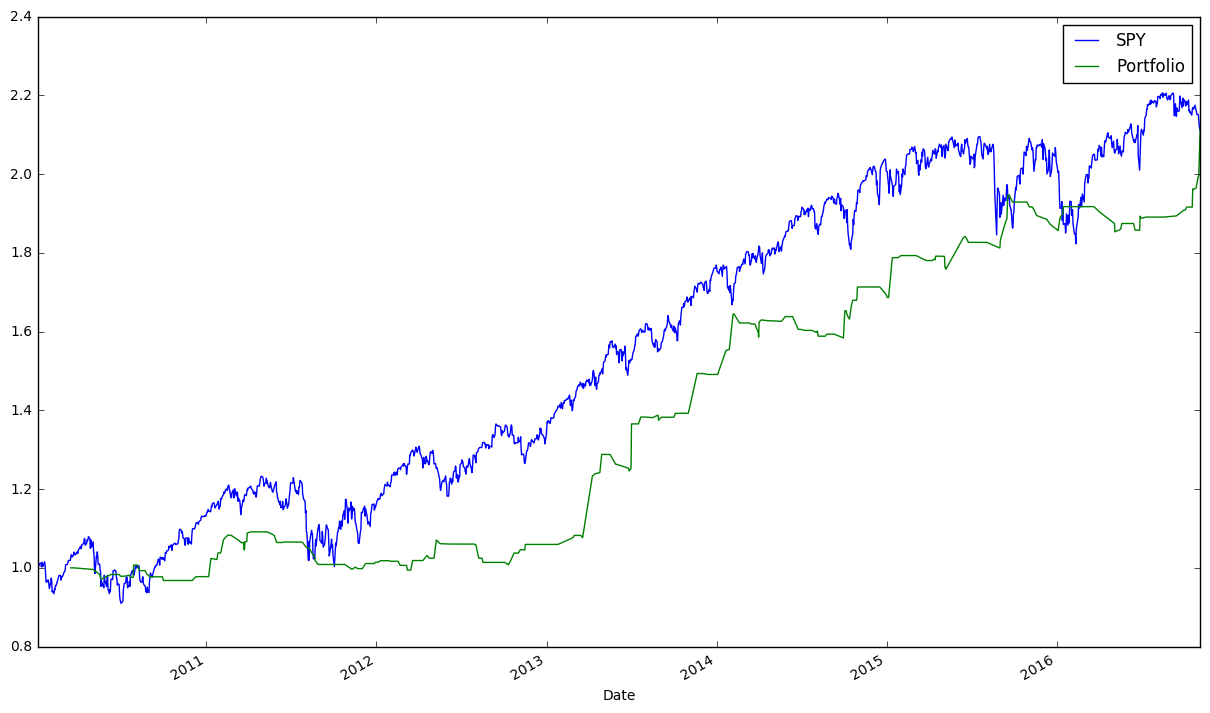

In [43]:
# We see that the buy-and-hold strategy beats the strategy we developed earlier. I would also like to see a plot.
ax_bench = (spyder["Adj Close"] / spyder.ix[0, "Adj Close"]).plot(label = "SPY")
ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 1000000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
ax_bench